# Named entity recognition

The exercise shows how we may extract elements such as names of companies, countries and similar objects from text.

In [164]:
from tqdm import tqdm
import sys
import os
import requests
import regex
from collections import Counter
import xml.etree.ElementTree as ET
import pandas as pd

In [111]:
ustawy_path = '../ustawy'
ustawy_tagged_path = 'tagged_ustawy'

## Sort bills according to their size and take top 50 (largest) bills.

In [112]:
legislation_acts = {}

with tqdm(total=1179, file=sys.stdout) as pbar: 
    for filename in os.listdir(ustawy_path):
            with open(ustawy_path + '/' + filename, 'r', encoding='utf8') as f:
                content = f.read()
                legislation_acts[filename] = content
                pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████| 1179/1179 [00:05<00:00, 212.35it/s]


In [113]:
longest_legislation_acts = list(legislation_acts.items())
longest_legislation_acts.sort(reverse=True, key=lambda a: len(a[1]))
longest_legislation_acts = longest_legislation_acts[:50]

In [114]:
new_line_re = regex.compile(r'\n+|\s+|\t+')
longest_legislation_acts = [(name, new_line_re.sub(' ', act)) for name, act in longest_legislation_acts]

## Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence.

In [115]:
def tag_text(text):
    response = requests.post("http://localhost:9200", data=text.encode("utf-8"))
    return response.content.decode("utf-8")

In [116]:
legislation_acts_tagged = {}

In [117]:
# with tqdm(total=len(longest_legislation_acts), file=sys.stdout) as pbar:
#     for filename, text in longest_legislation_acts:
#         legislation_acts_tagged[filename] = tag_text(text)
#         pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [17:44<00:00, 21.29s/it]


In [118]:
# for filename, tagged_content in legislation_acts_tagged.items():
#     with open(ustawy_tagged_path + '/' + filename, 'w+', encoding='utf-8') as f:
#         f.write(tagged_content)

In [119]:
with tqdm(total=len(os.listdir(ustawy_tagged_path)), file=sys.stdout) as pbar:
    for filename in os.listdir(ustawy_tagged_path):
            with open(ustawy_tagged_path + '/' + filename, 'r', encoding='utf8') as f:
                tagged_content = f.read()
                legislation_acts_tagged[filename] = tagged_content
                pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 75.20it/s]


In [120]:
print(list(legislation_acts_tagged.items())[0][1])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [143]:
def basic_named_entity_recongnition(tags):
    result = []
    c = ""
    for i in range(len(tags)):
        if tags[i][0][0].isupper() and (i == 0 or tags[i-1][0] != '.'):
            if tags[i-1][0][0].isupper():
                if c == "":
                    c = tags[i][1]
                else: 
                    c = c + " " + tags[i][1]
            else:
                if c == "":
                    result.append(tags[i][1])
                else:    
                    result.append(c)
                    c = ""
    return Counter(result)
    

In [144]:
def mapper(l):
    filtered = list(filter(lambda x: x is not None, l))
    result = []
    for i in range(len(filtered)):
        if i % 2 == 1:
            result.append([filtered[i-1], filtered[i]])
    return result        
        

tags = [mapper(list(map(lambda x: x.split()[0] if x.split() != [] else None, c.split('\n')))) for n, c in legislation_acts_tagged.items()]
print(tags[0][:100])

[['Dz', 'dziennik'], ['.', '.'], ['U', 'ustawa'], ['.', '.'], ['z', 'z'], ['1998', '1998'], ['r', 'rok'], ['.', '.'], ['Nr', 'numer'], ['106', '106'], [',', ','], ['poz', 'pozycja'], ['.', '.'], ['668', '668'], ['USTAWA', 'ustawa'], ['z', 'z'], ['dnia', 'dzień'], ['24', '24'], ['lipca', 'lipiec'], ['1998', '1998'], ['r', 'rok'], ['.', '.'], ['o', 'o'], ['zmianie', 'zmiana'], ['niektórych', 'niektóry'], ['ustaw', 'ustawa'], ['określających', 'określać'], ['kompetencje', 'kompetencja'], ['organów', 'organ'], ['administracji', 'administracja'], ['publicznej', 'publiczny'], ['-', '-'], ['w', 'w'], ['związku', 'związek'], ['z', 'z'], ['reformą', 'reforma'], ['ustrojową', 'ustrojowy'], ['państwa', 'państwo'], ['Art', 'artykuł'], ['.', '.'], ['1', '1'], ['.', '.'], ['W', 'w'], ['ustawie', 'ustawa'], ['z', 'z'], ['dnia', 'dzień'], ['24', '24'], ['marca', 'marzec'], ['1920', '1920'], ['r', 'rok'], ['.', '.'], ['o', 'o'], ['nabywaniu', 'nabywać'], ['nieruchomości', 'nieruchomość'], ['przez', 'pr

In [145]:
counter = Counter([])
for tag in tags:
    counter += basic_named_entity_recongnition(tag)

## Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [146]:
counter.most_common()[:50]

[('numer', 3828),
 ('artykuł', 1216),
 ('dziennik', 1106),
 ('polski', 849),
 ('europejski', 549),
 ('minister', 446),
 ('państwo', 399),
 ('kodeks', 342),
 ('urząd', 291),
 ('graniczny', 276),
 ('chory', 270),
 ('Rzeczpospolita', 268),
 ('fundusz', 258),
 ('prezes', 239),
 ('policja', 238),
 ('straż pożarny', 231),
 ('prawo', 219),
 ('zakład', 218),
 ('obrona narodowy', 201),
 ('sprawiedliwość', 195),
 ('komisja wyborczy', 176),
 ('państwowy', 171),
 ('azot', 164),
 ('rada', 162),
 ('zmiana', 162),
 ('rada minister', 152),
 ('nadzór wewnętrzny', 147),
 ('nawóz', 144),
 ('pozostały', 143),
 ('skarb', 141),
 ('tkanina', 141),
 ('I', 138),
 ('finanse', 137),
 ('II', 135),
 ('patentowy', 134),
 ('straż', 117),
 ('ubezpieczenie społeczny', 115),
 ('P2O5', 115),
 ('komisja', 114),
 ('porozumienie', 114),
 ('sprawa wewnętrzny', 107),
 ('handel', 105),
 ('ochrona państwo', 104),
 ('obszar gospodarczy', 103),
 ('Rzeczpospolita polski', 94),
 ('biuro', 94),
 ('III', 93),
 ('damski', 93),
 ('mas

## Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the n82 model.

In [175]:
def make_request(act):
    r = requests.post('https://ws.clarin-pl.eu/nlprest2/base/startTask', json={ 
        "lpmn":'any2txt|wcrft2|liner2({"model":"n82"})',
        "text": act
    })

    return r.text

def ask_clarin(acts):
    return {name: make_request(act) for name, act in acts}

acts_requests_ids = ask_clarin(longest_legislation_acts)

In [161]:
def get_response(request_id, file_name):
    status = requests.get('https://ws.clarin-pl.eu/nlprest2/base/getStatus/'+request_id).json()
    
    if status["status"] == "DONE":
        fileID = status["value"][0]["fileID"]
        t = requests.get("https://ws.clarin-pl.eu/nlprest2/base/download"+fileID).text
        return t
    else:
        print(f"{request_id} for {file_name} is not yet ready")
        return None
    
def get_responses(acts_requests_ids):
    result = {}
    for name in tqdm(acts_requests_ids):
        result[name] = get_response(acts_requests_ids[name], f"clarin_responses/clarin_response_{name}")
    return result    
        
clarin_dict = get_responses(acts_requests_ids)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:37<00:00,  6.76s/it]


In [188]:
def parse(root):
    result = []
    sent_id = 0
    for chunk in root:
        for sentence in chunk:
            for token in sentence:
                if token.tag == "tok":                    
                    orth_t = token.find("orth")
                    orth = orth_t.text if orth_t is not None else None
                    lex_t = token.find("lex")
                    lex = lex_t.find("base").text if lex_t is not None else None
                    ne_attrs = set([])

                    for token_lex in token:
                        if token_lex.tag == "ann":
                            for attr_name in token_lex.attrib:
                                if attr_name == "chan" and token_lex.attrib[attr_name].startswith("nam_"):
                                    if token_lex.text == "1":
                                        ne_attrs.add((token_lex.attrib[attr_name]))
                    result.append((orth, lex, sent_id, ne_attrs))
            sent_id += 1
    return result

def clarin_name_entity_recognition_single(name):
    root = ET.ElementTree(ET.fromstring(clarin_dict[name])).getroot()
    lexs = parse(root)
    cur_tags = {}
    result = []
    for lex in lexs:
        ctags = set(cur_tags.keys())
        new_tags = lex[3] - ctags
        cont_tags = lex[3] & ctags
        end_tags = ctags - lex[3]
        for t in new_tags:
            cur_tags[t] = [ lex ]
        for t in end_tags:
            res.append(cur_tags[t])
            del cur_tags[t]
        for t in cont_tags:
            cur_tags[t].append(lex)
    for t in cur_tags:
        result.append(cur_tags[t])
    return result

def clarin_name_entity_recognition(acts):
    res = []
    for name, _ in acts:
        for en in clarin_name_entity_recognition_single(name):
            cat = next(iter(en[0][3]))
            en_text = " ".join(map(lambda x: x[1], en))
            orig_text = " ".join(map(lambda x: x[0], en))
            res.append((en_text, orig_text, cat))
    return pd.DataFrame(data=res, columns=['lemmatized', 'original', 'category'])

clarin_entities = clarin_name_entity_recognition(longest_legislation_acts)

## Plot the frequency (histogram) of the coarse-grained classes (e.g. nam_adj, nam_eve, nam_fac).

In [189]:
clarin_entities["coarse_grained_category"] = clarin_entities["category"].apply(lambda x: f"{x.split('_')[0]}_{x.split('_')[1]}")

In [190]:
coarse_grained = clarin_entities.groupby("coarse_grained_category").agg({"lemmatized": "count"}).sort_values(["lemmatized"], ascending=[0])
coarse_grained

,lemmatized
coarse_grained_category,
nam_org,6722
nam_pro,3100
nam_loc,1089
nam_liv,598
nam_oth,383
nam_adj,312
nam_fac,132
nam_eve,33
nam_num,16


array([[<AxesSubplot:title={'center':'lemmatized'}>]], dtype=object)

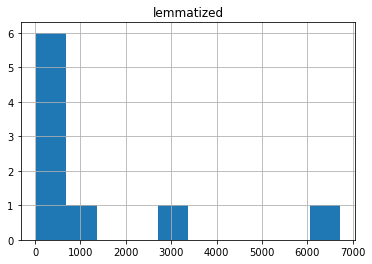

In [191]:
coarse_grained.hist(column="lemmatized")

## Display 10 most frequent Named Entities for each coarse-grained type.

In [207]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(clarin_entities.groupby("coarse_grained_category")["original"].apply(lambda x: list(x)[:10]))

coarse_grained_category
nam_adj                                                                                                                                                                       [polski, polskim, polskim, polskiego, warszawski, wojewódzkiego, polskie, polskimi, Wojewódzki, Wojewódzki]
nam_eve                      [Generalny Konserwator Zabytków, Ochrony Roślin, Monitorze Sądowym, Monitorze Sądowym, Monitorze Sądowym i Gospodarczym, Narodowy Bank Polski, Międzynarodowe Standardy Rachunkowości, II wojny światowej, Oddział 2 Tranzyt, X . Opieka domowa nad dziećmi]
nam_fac                                                                                              [Komendant Główny, Komendant Główny, Komendant Główny, Komendant Główny, Komendant Główny, Komendant Główny, Komendant Główny, Komendant Główny, Komendant Główny, Komendant Główny]
nam_liv     [Komendę Uzupełnień, M, Głównym Inspektorem, Głównego Inspektora, Głównego Inspektora, Głównego Inspektora, Głównego I

## Display 50 most frequent Named Entities including their count and fine-grained type.

In [202]:
clarin_entities.groupby("lemmatized").agg({ "original": "count", "category": "first" }).sort_values(["original"], ascending=[0])[:50]

,original,category
lemmatized,,
Dzieje_(Apostolskie) . u .,1081,nam_pro_media_periodic
rzeczpospolita polski,677,nam_loc_gpe_country
dziennik . u .,414,nam_pro_media_periodic
skarb państwo,307,nam_org_institution
minister sprawiedliwość,274,nam_org_institution
rada minister,262,nam_org_institution
minister obrona narodowy,226,nam_org_institution
unia europejski,226,nam_org_organization
państwowy komisja wyborczy,215,nam_org_institution


## Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color.

Pierwszeństwo do uzyskania patentu, prawa ochronnego albo prawa z rejestracji oznacza się, na zasadach określonych w umowach międzynarodowych, według daty wystawienia wynalazku, wzoru użytkowego albo wzoru przemysłowego w **Polsce** (nam_loc) lub za granicą, na wystawie międzynarodowej oficjalnej lub oficjalnie uznanej, jeżeli zgłoszenie w **Urzędzie Patentowym** (nam_org) tego wynalazku, wzoru użytkowego albo wzoru przemysłowego dokonane zostanie w okresie 6 miesięcy od tej daty. 



Pierwszeństwo do uzyskania patentu, prawa ochronnego albo prawa z rejestracji przysługuje także, na zasadach określonych w ust. 1, w przypadku wystawienia wynalazku, wzoru użytkowego albo wzoru przemysłowego na innej niż określona w ust. 1 wystawie publicznej w **Polsce** (nam_loc), wskazanej przez **Prezesa Urzędu Patentowego** (nam_org) w formie obwieszczenia w **Dzienniku Urzędowym Rzeczypospolitej Polskiej** (nam_pro) **"Monitor Polski"** (nam_pro). 

W przypadkach uzasadnionych potrzebą dokonywania odrębnych wpisów, w
  **Urzędzie Patentowym** (nam_org) prowadzone są pomocnicze rejestry praw udzielonych z mocą
  na terytorium **Rzeczypospolitej Polskiej** (nam_loc), zarejestrowanych w międzynarodowym
  organie na podstawie umowy międzynarodowej.

**Prezes Rady Ministrów** (nam_org) lub minister ogłosi w **Dzienniku Ustaw Rzeczypospolitej Polskiej** (nam_pro) jednolite teksty ustaw, o których mowa w art. 14, 15, 18, 19, 23, 27, 33, 36, 47, 50-53, 60, 61, 62, 64, 74-76, 78, 82, 86, 90, 91, 97, 107, 126, 137, 139 z uwzględnieniem zmian wynikających z przepisów ogłoszonych przed dniem wydania jednolitych tekstów ustaw. 

**Obsługę Rady Nadzorczej** (nam_org) i **Zarządu** (nam_loc) zapewnia biuro **Narodowego Funduszu** (nam_org).

## Answer the following questions:
-  Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names? n82 model
-  What are the drawbacks of the method based on capital letters? Not considering named entities containing words starting with lower letter
-  What are the drawbacks of the method based on NER? 
-  Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.
-  Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?
-  Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?
